<a href="https://colab.research.google.com/github/samyzaf/kerutils/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Recognition in CIFAR-10 Image Database

<a href="https://www.cs.toronto.edu/~kriz/cifar.html">
<img src="https://samyzaf.com/ML/cifar10/cifar1.jpg" style="max-width: 80%;" />
</a>

**CIFAR-10** is by now a classical computer-vision dataset for object recognition case study.
It is a subset of the **80 million** tiny images dataset that was designed and
created by the **Canadian Institute for Advanced Research** (CIFAR, pronounced "see far").

The **CIFAR-10** dataset consists of 60000 32x32x3 color images in 10 equal classes,
(6000 images per class).
Each class of images corresponds to a physical object (automobile, cat, dog, airplane, etc).
It was collected by **Alex Krizhevsky**, **Vinod Nair**, and **Geoffrey Hinton**.
We strongly recommend looking at the following two sources before starting work on this notebook:
1. http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
2. http://cs231n.github.io/convolutional-networks/

## Prerequisites
* We use the **kerutils** Python package
which can be downloaded from
https://samyzaf.com/kerutils.zip

* We also use the user's Google drive for saving models.


In [1]:
%pip install -q https://samyzaf.com/kerutils.zip
from kerutils import *
from tensorflow.keras.datasets import cifar10
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
workdir = "/content/drive/MyDrive/Colab Notebooks/ml/cifar10"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


The CIFAR-10 image classes are encoded as integers 0-9 by the following Python dictionary

In [2]:
num_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

## Load training and test data

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])  # somehow y_train comes as a 2D nx1 matrix
y_test = y_test.reshape(y_test.shape[0])

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'validation samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
X_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


The original data of each image is a 32x32x3 matrix of integers from 0 to 255.
We need to scale it down to floats in the unit interval

In [4]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

As usual, we must convert the **y_train** and **y_test** vectors to one-hot format:

<pre>
0 &rarr; [<b>1</b>, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 &rarr; [0, <b>1</b>, 0, 0, 0, 0, 0, 0, 0, 0]
2 &rarr; [0, 0, <b>1</b>, 0, 0, 0, 0, 0, 0, 0]
3 &rarr; [0, 0, 0, <b>1</b>, 0, 0, 0, 0, 0, 0]
etc...
</pre>

In [5]:
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

Let's also write two small utilities for drawing samples of images,
so we can inspect our results visually.

In [6]:
plt.rcParams['figure.figsize'] = (2,2)
def draw_img(i):
    im = X_train[i]
    c = y_train[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name[c]))
    plt.axis('on')

def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(32,32,3)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name[y[n+i]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

Let's draw image 7 in X_train for example

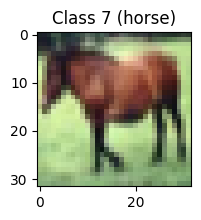

In [7]:
draw_img(7)

To test the second utility, let's draw the first 15 images in a 3x5 grid:

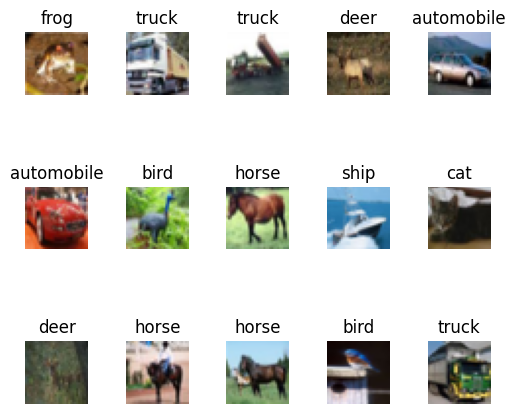

In [8]:
plt.rcParams['figure.figsize'] = (6,6)
draw_sample(X_train, y_train, 0, 3, 5)

In [9]:
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

# Building Neural Networks for CIFAR-10
In contrast to previous case studies, in this case it would be prohibitive to use fully
connected neural network unless we have good reasons to believe that we can make good
progress with a small number of neurons on layers beyond the input layer.
The input layer would have to be of size 3072 (as every image is a 32x32x3 matrix).
if we add a hidden layer with the same size, we'll end up with 9 milion
synapses on the first floor.
Adding one more layer of such size will take us to billions of synapses,
which is of course impractical.

Deep learning frameworks have come up with special types of designated layers for
processing images with minimal number of synapses (compared to **Dense** layer).
Each image pixel is connected to a very small subset of pixels of size 3x3 or 5x5 in its
neighborhood. Intuitively, image pixels are mostly impacted by pixels around them rather than
pixels in a far away region of the image.

These two types of layers are explained in more detail in the following two articles,
which we recommend to read before you approach the following code:
1. http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
2. http://cs231n.github.io/convolutional-networks/

We will start with a small Keras model which combines a well thought mix of Convolution2D, Maxpooling2D and Dense layers.
It is mostly based on open source code examples by **François Chollet**
(author of **Keras** from **Google**) and other similar sources:
1. https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
2. https://www.kaggle.com/okhan1/state-farm-distracted-driver-detection/testing-keras/run/232911
3. http://blog.schlerp.net/2016/7/neural-networks-in-python-3-keras

## Two Types of Training
We will use two types of training:
1. **Standard training:**
the usual Keras fit method
2. **Training with augmented data:**
In this mode, our training data is passing through a special Keras generator which
applies certain image operations on each data item and generates new items for training.
This way we can multiply our training data indefinitely as much as we wish and thus
provide our model with as much training as we wish (but of course we should avoid overfitting).

The Keras generator for the second training mode is called **ImageDataGenerator**
and can be understood from the Keras manual page:
<br/>
https://keras.io/preprocessing/image/#imagedatagenerator

## Lets Train Model 1 (standard training)

In [10]:
epochs = 50
batch_size = 64

model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=MaxNorm(3)))
model1.add(Dropout(0.2))
model1.add(Convolution2D(32, 3, 3, activation='relu', padding='same', kernel_constraint=MaxNorm(3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))
# Compile model
lrate = 0.01
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model1.summary())

print('Standard Training.')

h = model1.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test),
    shuffle=True
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 11, 11, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,322 (317.66 KB)

 Trainable params: 81,322 (317.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Standard Training.
Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2093 - loss: 2.1194 - val_accuracy: 0.3529 - val_loss: 1.7878
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3446 - loss: 1.8064 - val_accuracy: 0.4104 - val_loss: 1.6320
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3988 - loss: 1.6492 - val_accuracy: 0.4492 - val_loss: 1.5164
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4264 - loss: 1.5840 - val_accuracy: 0.4671 - val_loss: 1.4752
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4497 - loss: 1.5215 - val_accuracy: 0.4706 - val_loss: 1.4650
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4615 - loss: 1.4831 - val_accuracy: 0.4979 - val_loss: 1.3800
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4777 - loss: 1.4416 - val_accuracy: 0.5176 - val_loss: 1.3542
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4884 - loss: 

Training: accuracy   = 0.690000 loss = 0.873131
Validation: accuracy = 0.593100 loss = 1.148899
Over fitting score   = 0.010461
Under fitting score  = 0.015163
Params count: 81322
stop epoch = 49
epochs = 50


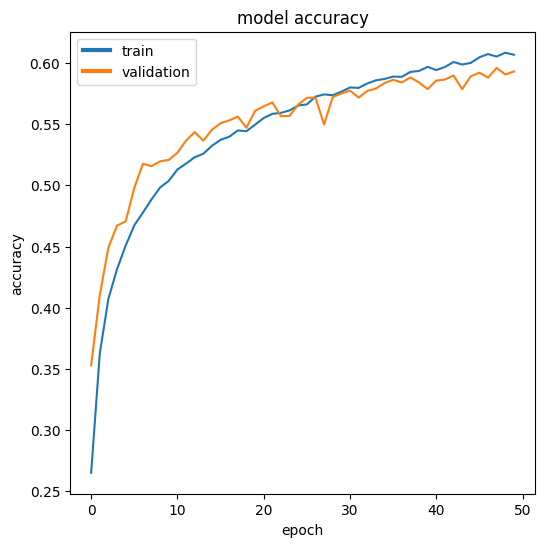

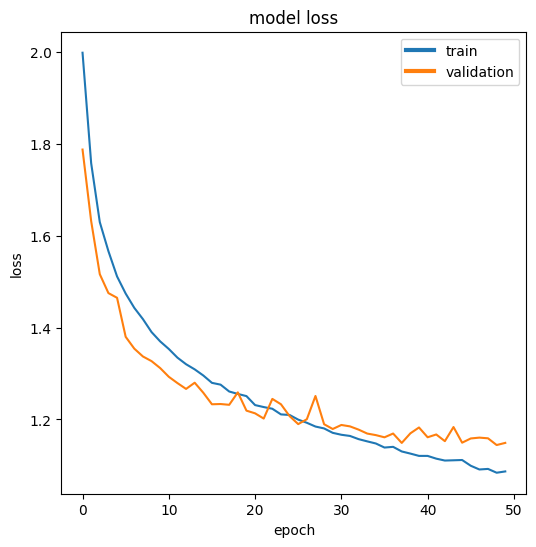

Saving model1 to the file "model1.keras"


'/content/drive/MyDrive/Colab Notebooks/ml/cifar10/model1.keras'

In [11]:
show_scores(model1, h, X_train, Y_train, X_test, Y_test)
print('Saving model1 to the file "model1.keras"')
model1.save("model1.keras")
shutil.copy("/content/model1.keras", workdir)

In [12]:
#Checking the size of mode1.keras
!du -sk model1.keras

672	model1.keras


In [13]:
loss, accuracy = model1.evaluate(X_train, Y_train, verbose=1)
print(f"Training: accuracy = {accuracy}  ;  loss = {loss}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6907 - loss: 0.8704
Training: accuracy = 0.6899999976158142  ;  loss = 0.873131275177002


In [14]:
loss, accuracy = model1.evaluate(X_test, Y_test, verbose=0)
print(f"Validation: accuracy1 = {accuracy}  ;  loss1 = {loss}")

Validation: accuracy1 = 0.5931000113487244  ;  loss1 = 1.148898720741272


What we see in the last two graphs is a classic example of **overfitting** phenomenon.
While the training accuracy has skyrocketed to 99.96% (**wow!!**),
our validation data comes to the rescue and cools down our enthusiasm: only 70.14%.
The almost 30% gap between the training data and validation data is a clear indication
of overfitting, and a good reason to abandone model1 and look for a better one.
We should also notice the clear big gap between the training loss and validation
loss. This is also a clear mark of overfitting that should raise a warning sign.

## Inspecting the output

Neverthelss, befor we search for a new model,
let's take a quick look on some of the cases
that our model1 missed.
It may give us clues on the strengths an weaknesses
of NN models, and what we can expect
from these artificial models.

The **predict_classes** method is helpful for getting a
vector (**y_pred**)
of the predicted classes of **model1**.
We should compare **y_pred** to the expected true classes
**y_test** in order to get
the false cases:

In [15]:
x_pred = model1.predict(X_test)
y_pred = np.argmax(x_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [16]:
true_preds = [(x,y) for (x,y,p) in zip(X_test, y_test, y_pred) if y == p]
false_preds = [(x,y,p) for (x,y,p) in zip(X_test, y_test, y_pred) if y != p]
print("Number of true predictions: ", len(true_preds))
print("Number of false predictions:", len(false_preds))

Number of true predictions:  5931
Number of false predictions: 4069


The array **false_preds** consists of all triples **(x,y,p)** where x is an image,
y is its true class, and p is the false predicted value of **model1**.

Lets visualize a sample of 15 items:

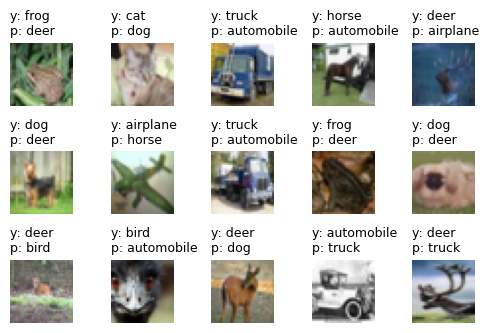

In [17]:
plt.figure(figsize=(6,4))
for i,(x,y,p) in enumerate(false_preds[0:15]):
    plt.subplot(3, 5, i+1)
    plt.imshow(x, cmap='gnuplot2')
    plt.title("y: %s\np: %s" % (class_name[y], class_name[p]), fontsize=9, loc='left')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

Well, we see that **model1** confuses between airplanes and sheep, dogs and cats, etc.
But we should not underestimate the fact that it is still correct in 60% of the cases,
which is highly untrivial!
(suppose that as a programmer you were assigned to write a traditional computer program
that can guess the class in 70% of the case - think how hard it would be...)

## Second Keras Model for the CIFAR-10 dataset
Lets try our small model with the aid of augmented data.
The **Keras ImageDataGenerator** is a great tool for
generating more training data from old data, so that we may have enough
training and avoid overfitting.

The **ImageDataGenerator** takes quite a few graphic parameters which we cannot explain
in this tutorial. We recommend reading the **Keras** documentation page and a short tutorial:
1. https://keras.io/preprocessing/image/#imagedatagenerator
2. http://machinelearningmastery.com/image-augmentation-deep-learning-keras/

Lets first take a look at a few samples of images that are genereated but **ImageDataGenerator**:

Number of images returned by iterator: 15


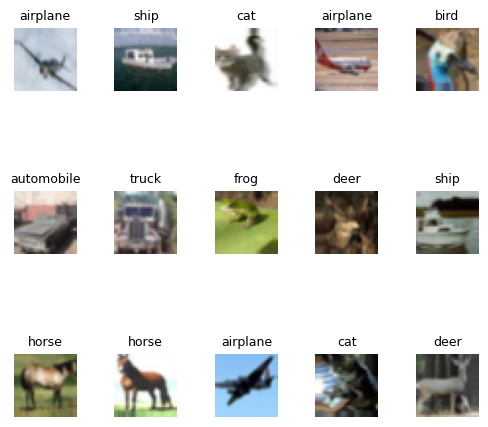

In [18]:
imdgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

imdgen.fit(X_train)
it = imdgen.flow(X_train, Y_train, batch_size=15) # This is a Python iterator
images, categories = next(it)
print("Number of images returned by iterator:", len(images))
for i in range(15):
    plt.subplot(3, 5, i+1)
    im = images[i]
    c = np.where(categories[i] == 1)[0][0] # convert one-hot to regular index
    plt.imshow(im, cmap='gnuplot2')
    plt.title(class_name[c], fontsize=9)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.6, hspace=0.2)

The images you see are not from the CIFAR-10 collection.
They were generated by **Keras ImageDataGenerator** from images in the CIFAR-10 database
by applying various image operators on them.
This way we can increase the number of training samples almost indefinitely
(in every training epoch we get a completely **new** set of samples!)

The second important point to note about this iterator is that it does not require
any memory or disk space to keep its images (no matter how many of them we want to make)!
It generates them in small batches (usually 32 or 128 at a time), and they are discarded after
model training. So we can train our model with millions of samples without using a memory
more than 100KB (for 32 batch size) or 400KB (for 128 batch size).
This is extremely important when our images are in real size (like 2048x3072).

Lets see now the second type of Keras training based on the **ImageDataGenerator**.
Note the new training method name: **fit_generator**.

### Model 2 (with Data Augmentation)

In [19]:
epochs = 100   # This time lets increase the number of epochs to 100
batch_size = 64

model2 = Sequential()
model2.add(Convolution2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=MaxNorm(3)))
model2.add(Dropout(0.2))
model2.add(Convolution2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=MaxNorm(3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))
# Compile model with SGD
lrate = 0.01
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=False)
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model2.summary())

print('Augmented Data Training.')

imdgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
imdgen.fit(X_train)

# fit the model on the batches generated by datagen.flow()
dgen = imdgen.flow(X_train, Y_train, batch_size=batch_size)
fmon = FitMonitor(thresh=0.03, minacc=0.98)  # this is from our kerutils module (see above)
h = model2.fit(
    dgen,
    steps_per_epoch = X_train.shape[0],
    epochs = epochs,
    validation_data = (X_test, Y_test),
    verbose = 1,
    #callbacks = [fmon]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,210,090 (16.06 MB)

 Trainable params: 4,210,090 (16.06 MB)

 Non-trainable params: 0 (0.00 B)

None
Augmented Data Training.
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  781/50000 ━━━━━━━━━━━━━━━━━━━━ 30:05 37ms/step - accuracy: 0.2640 - loss: 2.0124

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50000/50000 ━━━━━━━━━━━━━━━━━━━━ 34s 614us/step - accuracy: 0.3336 - loss: 1.8494 - val_accuracy: 0.4551 - val_loss: 1.5142
Epoch 2/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 37s 587us/step - accuracy: 0.4390 - loss: 1.5510 - val_accuracy: 0.4960 - val_loss: 1.4012
Epoch 3/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 27s 549us/step - accuracy: 0.4823 - loss: 1.4315 - val_accuracy: 0.5476 - val_loss: 1.2701
Epoch 4/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 28s 554us/step - accuracy: 0.5208 - loss: 1.3328 - val_accuracy: 0.5860 - val_loss: 1.1610
Epoch 5/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 41s 557us/step - accuracy: 0.5428 - loss: 1.2716 - val_accuracy: 0.5899 - val_loss: 1.1411
Epoch 6/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 28s 552us/step - accuracy: 0.5594 - loss: 1.2282 - val_accuracy: 0.6166 - val_loss: 1.0810
Epoch 7/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 28s 562us/step - accuracy: 0.5814 - loss: 1.1747 - val_accuracy: 0.6363 - val_loss: 1.0218
Epoch 8/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 28s 554us/step 

Training: accuracy   = 0.866020 loss = 0.404146
Validation: accuracy = 0.776500 loss = 0.684270
Over fitting score   = 0.019007
Under fitting score  = 0.028824
Params count: 4210090
stop epoch = 99
epochs = 100


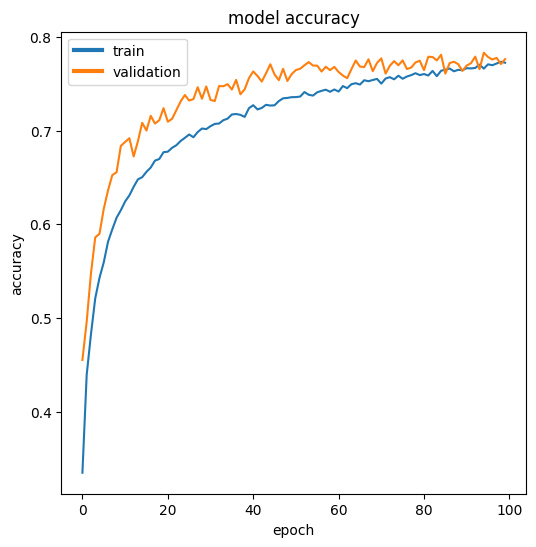

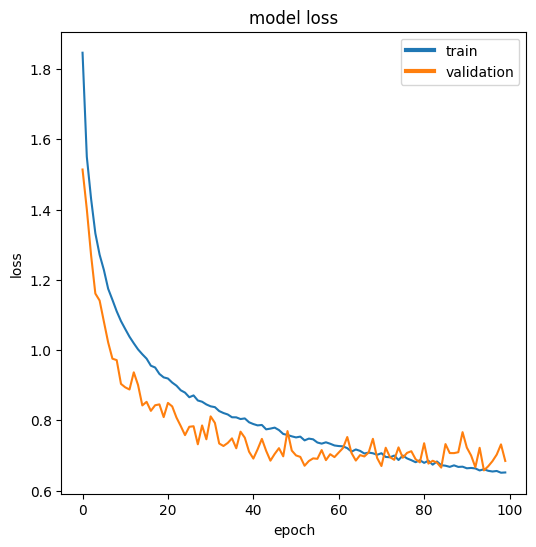

Saving model2 to "model2.keras"


'/content/drive/MyDrive/Colab Notebooks/ml/cifar10/model2.keras'

In [20]:
show_scores(model2, h, X_train, Y_train, X_test, Y_test)
print('Saving model2 to "model2.keras"')
model2.save("model2.keras")
shutil.copy("/content/model2.keras", workdir)

In [21]:
loss, accuracy = model2.evaluate(X_train, Y_train, verbose=1)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8665 - loss: 0.4004
Training: accuracy = 0.866020  ;  loss = 0.404146


In [22]:
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=1)
print(f"Validation: accuracy = {accuracy}  ;  loss = {loss}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7763 - loss: 0.6851
Validation: accuracy = 0.7764999866485596  ;  loss = 0.6842696666717529


Indeed, using convolutional layers has yielded better validation
(almost 10% more than the previous model).
Training accuracy has drastically dropped from 99.95% to less than 88.7%,
but this is not an indication for an inferior model.
On the contrary, the extreme overfitting that we got in model1 was a clear
indication of model inadequacy.
The overfitting that we see in model2 is not too bad, and it is better fit
for practical practices than model1.

Still, 80% is not good enough (it was super exceptional in the 90's :-)
and we should strive for more.
Looking at the precision and loss graphs, it doesn't look like we are going
to get much improvement in model2 by adding more epochs or tuning other parameters, although we encourage the students to try other optimizers and activation functions
(**Keras** has plenty of them) if a fast GPU is available for this.
Otherwise it can take a lot of time.
It took us about 3 hours to run 120 epochs on a NVIDIA GeForce GTX950,
so it could take days to try more epochs and different parameters,
unless you have an NVIDIA TITAN or TESLA cards.

In this tutorial we will continue and experiment with our medium and big models that contain
more layers and more neurons.

### Model 3 (with Data Augmentation)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 1, 1, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,050 (261.91 KB)

 Trainable params: 67,050 (261.91 KB)

 Non-trainable params: 0 (0.00 B)

None
Augmented Data Training.
Train begin: 2025-03-06 16:03:03
Stop file: stop_training_file.keras (create this file to stop training gracefully)
Pause file: pause_training_file.keras (create this file to pause training and view graphs)
epochs = 120
steps = 50000
verbose = 1
Epoch 1/120
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 35s 601us/step - accuracy: 0.1810 - loss: 2.1712 - val_accuracy: 0.2819 - val_loss: 1.9727
Epoch 2/120
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 34s 521us/step - accuracy: 0.2709 - loss: 1.9708 - val_accuracy: 0.3478 - val_loss: 1.7896
Epoch 3/120
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 26s 524us/step - accuracy: 0.3159 - loss: 1.8535 - val_accuracy: 0.4017 - val_loss: 1.6606
Epoch 4/120
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 26s 522us/step - accuracy: 0.3491 - loss: 1.7792 - val_accuracy: 0.4186 - val_loss: 1.6080
Epoch 5/120
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 27s 536us/step - accuracy: 0.3640 - loss: 1.7341 - val_accuracy: 0.4209 - val_loss: 1.5753
Epoch 6/120
50000/50000 ━━━━━━━━━━━━━━━━━━━━

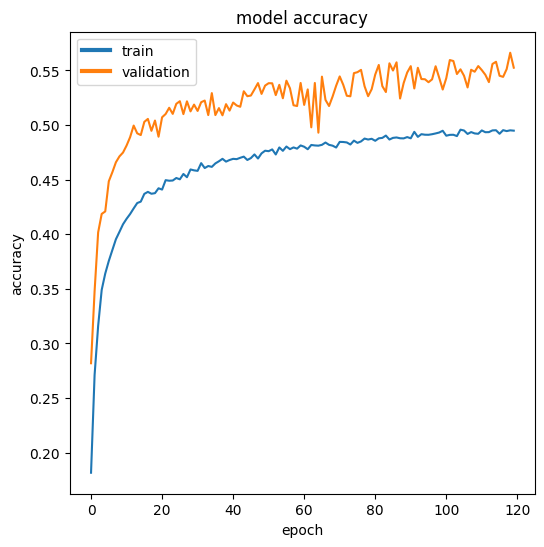

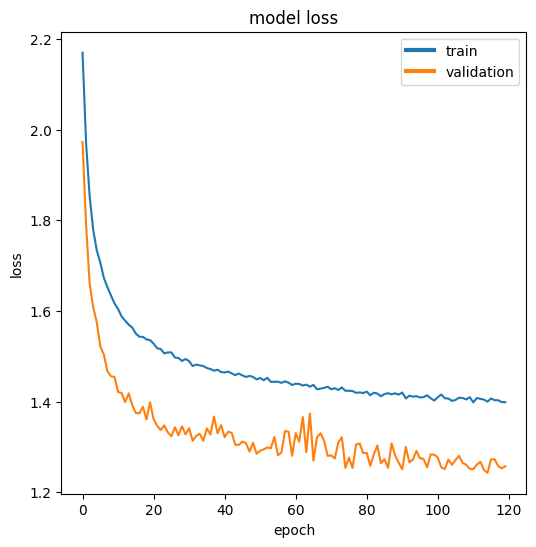

Saving model3 to "model3.keras"
Saving history dict to pickle file: hist3.p


In [23]:
epochs = 120
batch_size = 64

model3 = Sequential()
model3.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), padding='same', activation='relu', kernel_constraint=MaxNorm(3)))
model3.add(Dropout(0.2))
model3.add(Convolution2D(32, 3, 3, activation='relu', padding='same', kernel_constraint=MaxNorm(3)))
model3.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model3.add(Dropout(0.2))

model3.add(Convolution2D(64, 3, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes, activation='softmax'))

# Compile model with SGD (Stochastic Gradient Descent)
lrate = 0.01
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=False)
model3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model3.summary())

print('Augmented Data Training.')

imdgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
imdgen.fit(X_train)

# fit the model on the batches generated by datagen.flow()
dgen = imdgen.flow(X_train, Y_train, batch_size=batch_size)
fmon = FitMonitor(thresh=0.03, minacc=0.99)  # this is from our kerutils module (see above)
h = model3.fit(
    dgen,
    steps_per_epoch = X_train.shape[0],
    epochs = epochs,
    validation_data = (X_test, Y_test),
    verbose = 1,
    callbacks = [fmon]
)

show_scores(model3, h, X_train, Y_train, X_test, Y_test)
print('Saving model3 to "model3.keras"')
model3.save("model3.keras")
shutil.copy("/content/model3.keras", workdir)
print('Saving history dict to pickle file: hist3.p')
with open('hist3.p', 'wb') as f:
    pickle.dump(h.history, f)

In [24]:
loss, accuracy = model3.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.566540  ;  loss = 1.235977


In [25]:
loss, accuracy = model3.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.552500  ;  loss = 1.257359


Model3 size: 2.13M.
Training accuracy raised to 90%, and validation accuracy 83.7%.
There's still a 7% overfitting gap, and 83.7% validation is still not high enough.
Lets try harder.

### Model 4 (with Data Augmentation)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 11, 11, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 1, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 1, 1, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,978 (406.16 KB)

 Trainable params: 103,978 (406.16 KB)

 Non-trainable params: 0 (0.00 B)

None
Augmented Data Training.
Epoch 1/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 35s 618us/step - accuracy: 0.1576 - loss: 2.2018 - val_accuracy: 0.2695 - val_loss: 1.9833
Epoch 2/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 35s 562us/step - accuracy: 0.2724 - loss: 1.9643 - val_accuracy: 0.3482 - val_loss: 1.7866
Epoch 3/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 39s 528us/step - accuracy: 0.3238 - loss: 1.8309 - val_accuracy: 0.3793 - val_loss: 1.6823
Epoch 4/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 42s 559us/step - accuracy: 0.3474 - loss: 1.7654 - val_accuracy: 0.3963 - val_loss: 1.6447
Epoch 5/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 28s 551us/step - accuracy: 0.3631 - loss: 1.7214 - val_accuracy: 0.4134 - val_loss: 1.5991
Epoch 6/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 41s 550us/step - accuracy: 0.3758 - loss: 1.6918 - val_accuracy: 0.4271 - val_loss: 1.5492
Epoch 7/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 27s 534us/step - accuracy: 0.3887 - loss: 1.6585 - val_accuracy: 0.4420 - val_loss: 1.5270
Epoch 8/100
50000/

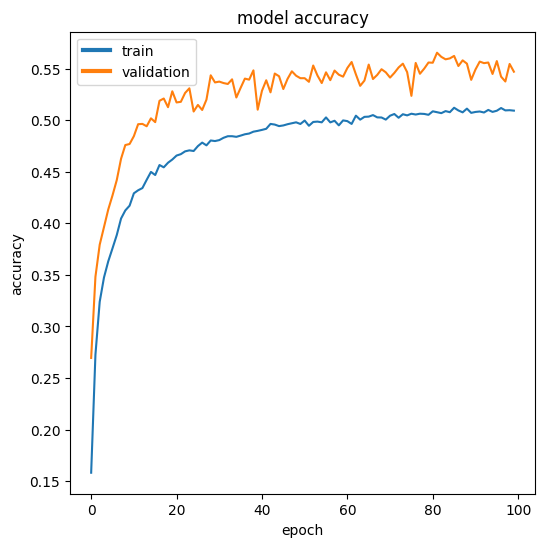

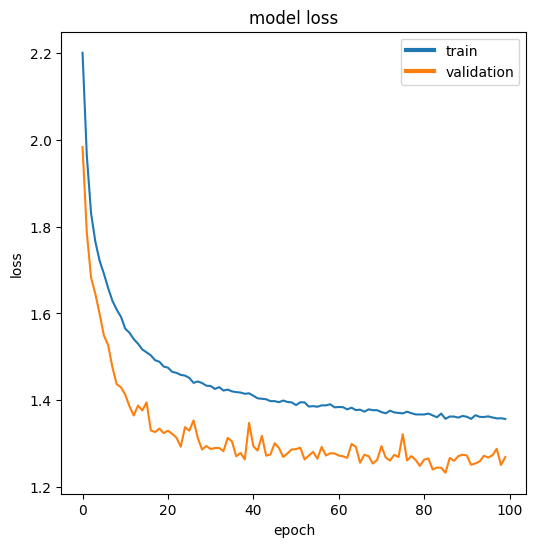

Saving model4 to "model4.keras"
Saving history dict to pickle file: hist4.p


In [26]:
epochs = 100
batch_size = 64

model4 = Sequential()
model4.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3), padding='same', activation='relu'))
model4.add(Dropout(0.2))
model4.add(Convolution2D(32, 3, 3, activation='relu', padding='same'))
model4.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model4.add(Dropout(0.2))

model4.add(Convolution2D(64, 3, 3, padding='same'))
model4.add(Activation('relu'))
model4.add(Convolution2D(64, 3, 3, padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(512, activation='relu', kernel_constraint=MaxNorm(3)))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes, activation='softmax'))


# Compile model with SGD (Stochastic Gradient Descent)
lrate = 0.01
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=True)
model4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model4.summary())

print('Augmented Data Training.')

imdgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
imdgen.fit(X_train)

# fit the model on the batches generated by datagen.flow()
dgen = imdgen.flow(X_train, Y_train, batch_size=batch_size)
#fmon = FitMonitor(thresh=0.03, minacc=0.99)  # this is from our kerutils module (see above)
h = model4.fit(
    dgen,
    steps_per_epoch = X_train.shape[0],
    epochs = epochs,
    validation_data = (X_test, Y_test),
    verbose = 1,
    #callbacks = [fmon]
)

show_scores(model4, h, X_train, Y_train, X_test, Y_test)
print('Saving model4 to "model4.keras"')
model4.save("model4.keras")
shutil.copy("/content/model4.keras", workdir)
print('Saving history dict to pickle file: hist4.p')
with open('hist4.p', 'wb') as f:
    pickle.dump(h.history, f)

In [27]:
loss, accuracy = model4.evaluate(X_train, Y_train, verbose=1)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5638 - loss: 1.2343
Training: accuracy = 0.561040  ;  loss = 1.238544


In [28]:
model4 = load_model("model4.keras")
#file_download("model4.keras")
loss, accuracy = model4.evaluate(X_test, Y_test, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5585 - loss: 1.2589
Validation: accuracy = 0.547000  ;  loss = 1.269088


Looks like we did it again: validation accuracy has risen to 88% but training accuracy is too high (99.77%) which is an indication of over fitting,
although not on the same scale as in model1 (30% gap).

We will take advantage of this situation to demonstrate how you can continue to train a model
from the last training point (it took 2.15 hours to reach the last model state).

To be safe we'll just copy model4 to model5 by simply loading the save file of model4 to a new
model. Then we will train model5 exactly as above.
We will give it extra 100 epochs and see where it will get us.

# Model 5

Let's first copy model4 to model5:

In [29]:
model5 = load_model("model4.keras")

Just for assurance, let's compute the training accuracy of model5
and see if we get the same scores as for model4

In [30]:
loss, accuracy = model5.evaluate(X_train, Y_train, verbose=1)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5638 - loss: 1.2343
Training: accuracy = 0.561040  ;  loss = 1.238544


In [31]:
loss, accuracy = model5.evaluate(X_test, Y_test, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5585 - loss: 1.2589
Validation: accuracy = 0.547000  ;  loss = 1.269088


Looks good. Lets try to train model5 with additional
samples generated by Keras ImageDataGenerator.
This time we'll add a small rotation angle of 5 degrees,
and set the shift ranges to 0.05.
We will also try a larger batch_size of 64 samples.

In [32]:
lrate = 0.01
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=False)
model5.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [33]:
loss, accuracy = model5.evaluate(X_test, Y_test, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5585 - loss: 1.2589
Validation: accuracy = 0.547000  ;  loss = 1.269088


Post Training
Train begin: 2025-03-06 18:31:21
Stop file: stop_training_file.keras (create this file to stop training gracefully)
Pause file: pause_training_file.keras (create this file to pause training and view graphs)
epochs = 100
steps = 50000
verbose = 1
Epoch 1/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 34s 600us/step - accuracy: 0.5220 - loss: 1.3294 - val_accuracy: 0.5509 - val_loss: 1.2418
Epoch 2/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 37s 568us/step - accuracy: 0.5208 - loss: 1.3308 - val_accuracy: 0.5519 - val_loss: 1.2516
Epoch 3/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 39s 530us/step - accuracy: 0.5223 - loss: 1.3277 - val_accuracy: 0.5603 - val_loss: 1.2319
Epoch 4/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 41s 540us/step - accuracy: 0.5229 - loss: 1.3249 - val_accuracy: 0.5554 - val_loss: 1.2512
Epoch 5/100
50000/50000 ━━━━━━━━━━━━━━━━━━━━ 26s 527us/step - accuracy: 0.5229 - loss: 1.3241 - val_accuracy: 0.5638 - val_loss: 1.2292
Epoch 6/100
  782/50000 ━━━━━━━━━━━━━━━━━━━━ 27:01 33ms/step

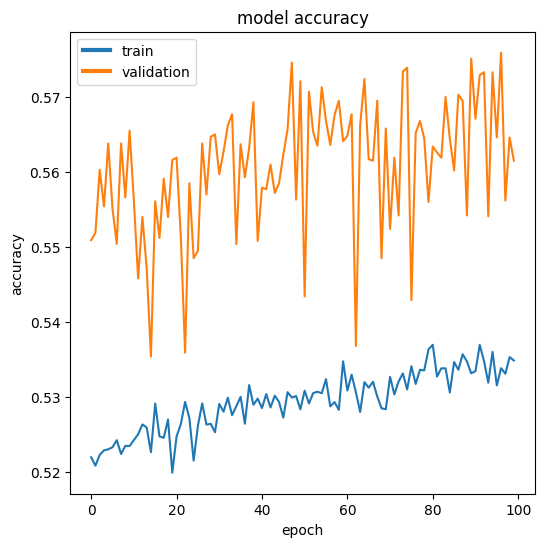

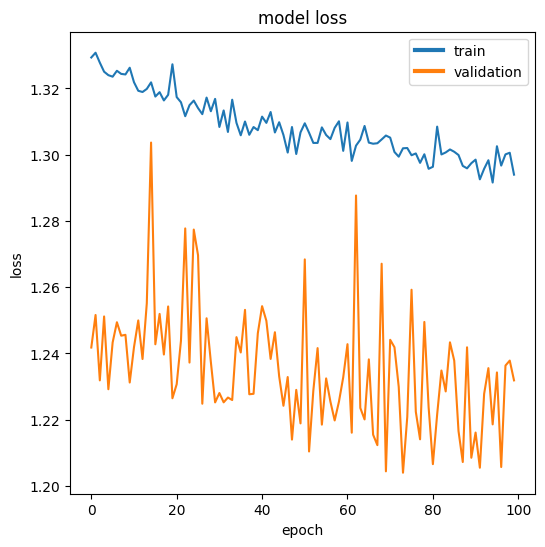

Saving model5 to "model5.keras"


In [34]:
epochs = 100
batch_size = 64

print('Post Training')

imdgen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 7,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.05,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.05,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = False,  # randomly flip images
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
imdgen.fit(X_train)

# fit the model on the batches generated by datagen.flow()
dgen = imdgen.flow(X_train, Y_train, batch_size=batch_size)
fmon = FitMonitor(thresh=0.03, minacc=0.99)  # this is from our kerutils module (see above)
h = model5.fit(
    dgen,
    steps_per_epoch = X_train.shape[0],
    epochs = epochs,
    validation_data = (X_test, Y_test),
    verbose = 1,
    callbacks = [fmon]
)

show_scores(model5, h, X_train, Y_train, X_test, Y_test)
print('Saving model5 to "model5.keras"')
model5.save("model5.keras")

In [35]:
loss, accuracy = model5.evaluate(X_train, Y_train, verbose=0)
print("Training: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.588080  ;  loss = 1.181827


In [36]:
loss, accuracy = model5.evaluate(X_test, Y_test, verbose=0)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.561500  ;  loss = 1.231861


We lost our patience after 70 epochs.
The graph suggests that if we wait long enough we may cross the 90% barrier.
Let's try instead another type of activation function **ReLU** (S-shaped Rectified Linear Unit).

## Project
Find photos of dogs, cats, and automobiles, on the internet or in your personnal photo albums,
and see if our models are recognizing them as such.
You will have to rescale your pictures to fit the model input shape.
Take a look at the next link to see how you can feed them to one of the models that we built in this tutorial.
<br/>
https://blog.rescale.com/neural-networks-using-keras-on-rescale/

Here is a simple minded way to do it (but read **scipy** manual to understand more):

In [ ]:
import numpy as np
from imageio import imread
from skimage.transform import resize
from keras.models import load_model

def rescale_image(image_file):
    im = resize(imread(image_file, 0, 'RGB'), (32, 32, 3))
    return im

def load_and_scale_imgs(img_files):
    imgs = [rescale_image(img_file) for img_file in img_files]
    return np.array(imgs)

model = load_model("model5.keras")   # This the last model we saved
#predictions = model.predict_classes(imgs)
predictions = np.argmax(model.predict(imgs), axis=-1)
for image_file,pred in zip(image_ficlass_nameedictions):
    print("%s: %s" % (image_file, class_name[pred]))
